# Home Work

В этой работе будем иследовать одну из популярнейших рекомендательных моделей - **Latent Factor Model** - https://arxiv.org/pdf/1912.04754. 

Перед выполнением задания нужно убедиться, что прогоняется бейзлайн. Для этого:
1. Скачайте  файлы - `node2name.json` и `clickstream.parquet` с необходимыми данными.
2. Положите в репозиторий ноутбука и запустите код.

В этой работе вам нужно:
1. Перебрать параметры модели - `edim`, `batch_size`, `lr`, `epoch`, `num_negatives` - (по **1 баллу - 5 балов**) 
2. Тип `OPTIMIZER_NAME` - (**4 балла за 5 оптимизаторов**)
3. На основе имеющихся данных собрать лучшую модель (по **precision@30**) и рассчитать ее метрики (**4 балла**)
4. Попробовать другие модели (например  `ALS` - https://benfred.github.io/implicit/ , `gru4rec`, `sasrec`) - за sasrec на хорошем уровне сразу **10 баллов**. За другие модели по **3 балла**
5. По окончанию работы в mlflow настроить графики для сравнения моделей. Можно проявить фантазию, но обязательно должно быть сравнение с бейзлайном (данный ноутбук) против других моделей
6. В `mlflow` залогировать последнюю версию ноутбука - необходимое условия. Либо в github, но тогда прикрепить ссылку в [mlflow](http://84.201.128.89:90/).
7. Эксперимент в формате - `homework-\<name\>`
8. Доп баллы (**20 баллов**) тому у кого будет наибольший скор на тесте. Но ваш ноутбук должен прогонятся и быть вопроизводимым.

Суммарно за работу **20 балов**.

# Installation

In [1]:
!pip freeze

alembic==1.13.1
aniso8601==9.0.1
anyio==4.3.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bleach==6.1.0
blinker==1.8.2
cachetools==5.3.3
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
cloudpickle==3.0.0
colorlog==6.8.2
comm==0.2.2
contourpy==1.2.1
cramjam==2.8.3
cycler==0.12.1
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
Deprecated==1.2.14
docker==7.0.0
docopt==0.6.2
entrypoints==0.4
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
fastparquet==2024.2.0
filelock==3.14.0
Flask==3.0.3
fonttools==4.51.0
fqdn==1.5.1
fsspec==2024.3.1
gitdb==4.0.11
GitPython==3.1.43
graphene==3.3
graphql-core==3.2.3
graphql-relay==3.2.0
greenlet==3.0.3
gunicorn==22.0.0
h11==0.14.0
httpcore==1.0.5
httpx==0.27.0
huggingface-hub==0.22.2
idna==3.7
importlib-metadata==7.0.0
ipykernel==6.29.4
ipython==8.12.3
ipywidgets==8.1.3
isoduration==20.11.0
itsdangero

In [2]:
!pip install mlflow==2.12.2
!pip install -U optuna

In [249]:
import os
import json
import random
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output
import mlflow

import optuna
import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader

In [254]:
MLFLOW_ADDRESS = "http://84.201.128.89:90/"
EXPERIMENT_NAME = "homework-donskoy"

mlflow.set_tracking_uri(MLFLOW_ADDRESS)
mlflow.set_experiment(EXPERIMENT_NAME)

NOTEBOOK_PARAMS = {
    "df_limit": 100_000,
    "notebook_path": "./HomeWork.ipynb",
    "node2name": "./node2name.json",
    "clickstream": "./clickstream.parquet",
    "seed": 42,
}

In [5]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(NOTEBOOK_PARAMS["seed"])

# Utils

In [6]:
class RecDataset(Dataset):
    def __init__(self, users, items, item_per_users):
        self.users = users
        self.items = items
        self.item_per_users=item_per_users

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx: int):
        user = self.users[idx]
        return torch.tensor(user), torch.tensor(self.items[idx]), self.item_per_users[user]

In [7]:
class LatentFactorModel(nn.Module):
    def __init__(self, edim, user_indexes, node_indexes):
        super(LatentFactorModel, self).__init__()
        self.edim = edim
        self.users = nn.Embedding(max(user_indexes) + 1, edim)
        self.items = nn.Embedding(max(node_indexes) + 1, edim)

    def forward(self, users, items):
        user_embedings = self.users(users).reshape(-1, self.edim)
        item_embedings = self.items(items)
        # (n_users; edim) + (batch; n_items; edim) = (batch, n_items)
        res = torch.einsum('be,bne->bn', user_embedings, item_embedings)
        return res 

    def pred_top_k(self, users, K: int):
        user_embedings = self.users(users).reshape(-1, self.edim )
        item_embedings = self.items.weight
        # (n_users; edim) + (n_items; edim) = (n_users, n_items)
        res = torch.einsum('ue,ie->ui', user_embedings, item_embedings)
        return torch.topk(res, K, dim=1)

In [8]:
def collate_fn(batch, num_negatives, num_items):
    users, target_items, users_negatives = [], [], []
    
    for triplets in batch:
        user, target_item, seen_item = triplets
        
        users.append(user)
        target_items.append(target_item)
        user_negatives = []
        
        while len(user_negatives)< num_negatives:
            candidate = random.randint(0, num_items)
            if candidate not in seen_item:
                user_negatives.append(candidate)
                
        users_negatives.append(user_negatives)
                
    positive = torch.ones(len(batch), 1)       
    negatives = torch.zeros(len(batch), num_negatives)
    labels = torch.hstack([positive, negatives])
    items = torch.hstack([
        torch.tensor(target_items).reshape(-1, 1), 
        torch.tensor(users_negatives)
    ])
    return torch.hstack(users), items, labels

In [9]:
def calculate_hitrate(df_preds: pd.DataFrame, K: int):
    return df_preds[
        df_preds['rank'] < K
    ].groupby('user_index')['relevant'].max().mean()

def calculate_precision(df_preds: pd.DataFrame, K: int):
    return (
        df_preds[
            df_preds['rank'] < K
        ].groupby('user_index')['relevant'].mean()
    ).mean()

In [10]:
def plot(metrics: dict[str, list[float]]):
    clear_output(wait=True)
    fig, (loss, hitrate, precision) = plt.subplots(1, 3, figsize=[18, 5])
    
    loss.plot(
        metrics["losses"],
        label='Loss', 
        c='black',
    )
    hitrate.plot(
        metrics["hitrate"],
        label='Hitrate', 
        c='black',
    )
    precision.plot(
        metrics["precision"],
        label='Precision', 
        c='black',
    )
    
    loss.legend()
    hitrate.legend()
    precision.legend()
    plt.show()
    return fig

In [11]:
def get_preds(model, df: pd.DataFrame, run_params):
    users = df['user_index'].unique()
    preds = model.pred_top_k(
        torch.tensor(users), run_params["K"]
    )[1].numpy()
    df_preds = pd.DataFrame({
        'node_index': list(preds), 
        'user_index': users, 
        'rank': [
            [j for j in range(0, run_params["K"])]
            for i in range(len(preds))
        ]
    })
    
    df_preds = df_preds.explode(['node_index', 'rank']).merge(
        df[['user_index', 'node_index']].assign(relevant=1).drop_duplicates(),
        on=['user_index', 'node_index'],
        how='left',
    )
    df_preds['relevant'] = df_preds['relevant'].fillna(0)

    return df_preds

# Data preparing

In [12]:
with open(NOTEBOOK_PARAMS["node2name"], mode='r', encoding='utf-8') as file:
    node2name = json.load(file)

node2name = {int(k): v for k, v in node2name.items()}

In [13]:
df = pd.read_parquet(NOTEBOOK_PARAMS["clickstream"])
df = df.head(NOTEBOOK_PARAMS["df_limit"])

In [14]:
df['is_train'] = (
    df['event_date'] < df['event_date'].max() - pd.Timedelta('2 day')
)

df['names'] = df['node_id'].map(node2name)

In [15]:
train_cooks = df[df['is_train']]['cookie_id'].unique()
train_items = df[df['is_train']]['node_id'].unique()

df = df[
    (df['cookie_id'].isin(train_cooks))
    & 
    (df['node_id'].isin(train_items))
]

user_indes, index2user_id = pd.factorize(df['cookie_id'])
df.loc[:, 'user_index'] = user_indes

node_indes, index2node = pd.factorize(df['node_id'])
df.loc[:, 'node_index'] = node_indes

df_train, df_val = df[df['is_train']], df[~df['is_train']]
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print(
    f'Train shape: {df_train.shape}\n'
    f'Val   shape: {df_val.shape}'
)

Train shape: (96611, 7)
Val   shape: (3333, 7)


In [16]:
user2seen = df_train.groupby('user_index')['node_index'].agg(
    lambda x: list(set(x))
)

In [17]:
df_train.sample(5)

,cookie_id,event_date,node_id,is_train,names,user_index,node_index
53975,19993538968,2024-04-02 09:45:56,1047673,True,root -> Животные -> Собаки -> Другая,913,966
12309,19804761698,2024-03-13 12:41:44,1047771,True,root -> Для дома и дачи -> Бытовая техника -> ...,186,50
56610,20001538546,2024-04-13 11:25:34,1054312,True,root -> Хобби и отдых -> Спорт и отдых -> Туризм,962,369
5343,19780011687,2024-03-12 03:28:59,1158205,True,root -> Для дома и дачи -> Ремонт и строительс...,98,222
2360,19768262116,2024-04-05 11:02:25,1054821,True,"root -> Недвижимость -> Дома, дачи, коттеджи -...",52,244


# Baseline (LFM)

In [49]:
RUN_PARAMS = {
    "batch_size": 50_000,
    "n_negatives": 5,
    "edim": 128,
    "n_epochs": 10,
    "optimizer_name": "Adam",
    "learning_rate": 1,
    "n_workers": 0,
    "K": 30,
}

In [ ]:
train_dataset = RecDataset(
    df_train['user_index'].values, 
    df_train['node_index'].values, 
    user2seen,
)

dataloader = DataLoader(
    train_dataset, 
    shuffle=True, 
    num_workers=RUN_PARAMS["n_workers"],
    batch_size=RUN_PARAMS["batch_size"],
    collate_fn=lambda batch: collate_fn(
        batch=batch, 
        num_negatives=RUN_PARAMS["n_negatives"], 
        num_items=df['node_index'].max(),
    ),
)

In [ ]:
model = LatentFactorModel(
    RUN_PARAMS["edim"], user_indes, node_indes,
)

optimizers = {
    "Adam": torch.optim.Adam(model.parameters(), RUN_PARAMS["learning_rate"]),
    "SGD": torch.optim.SGD(model.parameters(), RUN_PARAMS["learning_rate"]),
    "RMSprop": torch.optim.RMSprop(model.parameters(), RUN_PARAMS["learning_rate"]),
    "LBFGS": torch.optim.LBFGS(model.parameters(), RUN_PARAMS["learning_rate"]),
    "Adagrad": torch.optim.Adagrad(model.parameters(), RUN_PARAMS["learning_rate"]),
}

optimizer = optimizers[RUN_PARAMS["optimizer_name"]]

In [ ]:
epoch_bar = tqdm(range(RUN_PARAMS["n_epochs"]))

metrics = {
    "losses": [],
    "hitrate": [],
    "precision": [],
}

for epoch in epoch_bar:    
    metrics["loader_losses"] = []
    model.train()
    for (users, items, labels) in dataloader:
        optimizer.zero_grad()
        logits = model(users, items)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            logits, labels,
        )
        loss.backward()
        optimizer.step()

        loader_loss = loss.item()
        metrics["loader_losses"].append(loader_loss)

    # Metrics
    with torch.no_grad():
        model.eval()
        df_preds = get_preds(model, df_val, RUN_PARAMS)
        epoch_loss = sum(metrics["loader_losses"]) / len(metrics["loader_losses"])
        hitrate = calculate_hitrate(df_preds, RUN_PARAMS["K"])
        precision = calculate_precision(df_preds, RUN_PARAMS["K"])

    del df_preds
    
    metrics["losses"].append(epoch_loss)
    metrics["hitrate"].append(hitrate)
    metrics["precision"].append(precision)
    
    epoch_bar.set_description(f"EPOCH LOSS = {epoch_loss:.4f}")
    fig = plot(metrics)

In [ ]:
with mlflow.start_run(run_name="baseline_LFM"):
    for param, value in NOTEBOOK_PARAMS.items():
        mlflow.log_param(param, value)

    for param, value in RUN_PARAMS.items():
        mlflow.log_param(param, value)

    df_preds = get_preds(model, df_val, RUN_PARAMS)
    hitrate = calculate_hitrate(df_preds, RUN_PARAMS["K"])
    precision = calculate_precision(df_preds, RUN_PARAMS["K"])
    print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")

    mlflow.log_metrics(
        {
            'hitrate': hitrate,
            'precision': precision, 
        }
    )
    mlflow.log_artifact(NOTEBOOK_PARAMS["notebook_path"])
    mlflow.log_figure(fig, "metrics.png")

# Baseline (top-popular)

In [ ]:
top_popular = (
    df_train[['node_index']]
    .assign(v=1)
    .groupby('node_index')
    .count()
    .reset_index()
    .sort_values(by='v')
    .tail(RUN_PARAMS["K"])['node_index'].values
)

In [ ]:
users = df_val['user_index'].unique()
df_preds_top_poplular = pd.DataFrame({
    'node_index': [list(top_popular) for i in users], 
    'user_index': users, 
    'rank': [
        [j for j in range(0, RUN_PARAMS["K"])]
        for i in range(len(users))
    ]
})

df_preds_top_poplular = df_preds_top_poplular.explode([
    'node_index', 'rank',
]).merge(
    df_val[['user_index', 'node_index']].assign(relevant=1).drop_duplicates(),
    on=['user_index', 'node_index'],
    how='left',
)
df_preds_top_poplular['relevant'] = df_preds_top_poplular['relevant'].fillna(0)

In [ ]:
with mlflow.start_run(run_name="baseline_top_popular"):
    for param, value in NOTEBOOK_PARAMS.items():
        mlflow.log_param(param, value)

    for param, value in RUN_PARAMS.items():
        mlflow.log_param(param, None)

    hitrate = calculate_hitrate(df_preds_top_poplular, RUN_PARAMS["K"])
    precision = calculate_precision(df_preds_top_poplular, RUN_PARAMS["K"])
    print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")

    mlflow.log_metrics(
        {
            'hitrate': hitrate,
            'precision': precision, 
        }
    )
    mlflow.log_artifact(NOTEBOOK_PARAMS["notebook_path"])
    mlflow.log_figure(fig, "metrics.png")

# Experiments

In [56]:
def run(
    batch_size, n_negatives, edim, n_epochs, 
    optimizer_name, learning_rate, n_trials,
    run_name: str = "baseline",
) -> float:
    run_params = {
        "batch_size": batch_size,
        "n_negatives": n_negatives,
        "edim": edim,
        "n_epochs": n_epochs,
        "optimizer_name": optimizer_name,
        "learning_rate": learning_rate,
        "n_workers": 0,
        "K": 30,
        "n_trials": n_trials,
    }
    train_dataset = RecDataset(
        df_train['user_index'].values, 
        df_train['node_index'].values, 
        user2seen,
    )
    
    dataloader = DataLoader(
        train_dataset, 
        shuffle=True, 
        num_workers=run_params["n_workers"],
        batch_size=run_params["batch_size"],
        collate_fn=lambda batch: collate_fn(
            batch=batch, 
            num_negatives=run_params["n_negatives"], 
            num_items=df['node_index'].max(),
        ),
    )
    
    model = LatentFactorModel(
        run_params["edim"], user_indes, node_indes,
    )
    optimizers = {
        "Adam": torch.optim.Adam(model.parameters(), run_params["learning_rate"]),
        "SGD": torch.optim.SGD(model.pbarameters(), run_params["learning_rate"]),
        "RMSprop": torch.optim.RMSprop(model.parameters(), run_params["learning_rate"]),
        "AdamW": torch.optim.AdamW(model.parameters(), run_params["learning_rate"]),
        "Adagrad": torch.optim.Adagrad(model.parameters(), run_params["learning_rate"]),
    }
    optimizer = optimizers[run_params["optimizer_name"]]

    print(run_params)
    
    epoch_bar = tqdm(range(run_params["n_epochs"]))
    metrics = {
        "losses": [],
        "hitrate": [],
        "precision": [],
    }
    
    for epoch in epoch_bar:    
        metrics["loader_losses"] = []
        model.train()
        for (users, items, labels) in dataloader:
            optimizer.zero_grad()
            logits = model(users, items)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(
                logits, labels,
            )
            loss.backward()
            optimizer.step()
    
            loader_loss = loss.item()
            metrics["loader_losses"].append(loader_loss)
    
        # Metrics
        with torch.no_grad():
            model.eval()
            df_preds = get_preds(model, df_val, run_params)
            epoch_loss = sum(metrics["loader_losses"]) / len(metrics["loader_losses"])
            hitrate = calculate_hitrate(df_preds, run_params["K"])
            precision = calculate_precision(df_preds, run_params["K"])
    
        del df_preds
        
        metrics["losses"].append(epoch_loss)
        metrics["hitrate"].append(hitrate)
        metrics["precision"].append(precision)
        
        epoch_bar.set_description(f"EPOCH LOSS = {epoch_loss:.4f}")
        fig = plot(metrics)

    with mlflow.start_run(run_name=run_name):
        for param, value in NOTEBOOK_PARAMS.items():
            mlflow.log_param(param, value)
    
        for param, value in run_params.items():
            mlflow.log_param(param, value)

        with torch.no_grad():
            model.eval()
            df_preds = get_preds(model, df_val, run_params)
            
        hitrate = calculate_hitrate(df_preds, run_params["K"])
        precision = calculate_precision(df_preds, run_params["K"])
        print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")
    
        mlflow.log_metrics(
            {
                'hitrate': hitrate,
                'precision': precision, 
            }
        )
        mlflow.log_artifact(NOTEBOOK_PARAMS["notebook_path"])
        mlflow.log_figure(fig, "metrics.png")

    return precision

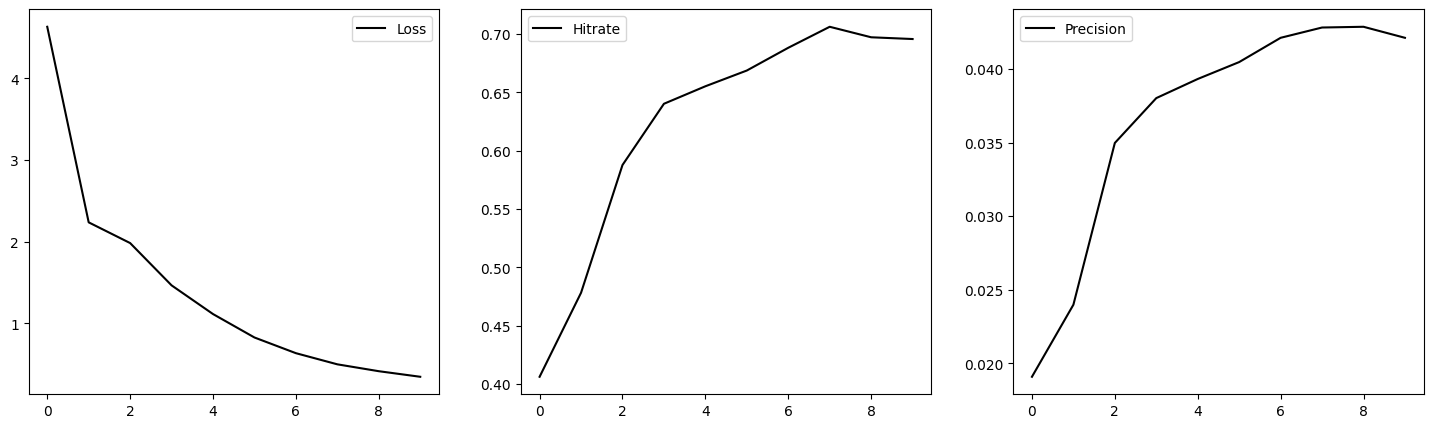

EPOCH LOSS = 0.3476: 100%|██████████████████████| 10/10 [00:53<00:00,  5.31s/it]


Hitrate: 0.6957 | Precision: 0.0421


In [52]:
# Repeat baseline
seed_everything(NOTEBOOK_PARAMS["seed"])
precision = run(
    batch_size=RUN_PARAMS["batch_size"], 
    n_negatives=RUN_PARAMS["n_negatives"], 
    edim=RUN_PARAMS["edim"], 
    n_epochs=RUN_PARAMS["n_epochs"], 
    optimizer_name=RUN_PARAMS["optimizer_name"], 
    learning_rate=RUN_PARAMS["learning_rate"], 
    n_trials=N_TRIALS,
    run_name='baseline',
)

In [60]:
N_TRIALS = 50

In [61]:
def objective(trial) -> float:
    seed_everything(NOTEBOOK_PARAMS["seed"])
    batch_size = trial.suggest_categorical('batch_size', [5000, 10000, 30000, 50000])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-2, 10)
    n_negatives = trial.suggest_int('n_negatives', 1, 10)
    edim = trial.suggest_int('edim', 32, 256)
    n_epochs = trial.suggest_int('n_epochs', 5, 30)
    optimizer_name = trial.suggest_categorical("optimizer_name", [
        "Adam", "SGD", "RMSprop", "AdamW", "Adagrad",
    ])
    
    precision = run(
        batch_size=batch_size, 
        n_negatives=n_negatives, 
        edim=edim, 
        n_epochs=n_epochs, 
        optimizer_name=optimizer_name, 
        learning_rate=learning_rate, 
        n_trials=N_TRIALS,
        run_name='LFM_optuna',
    )
    return precision

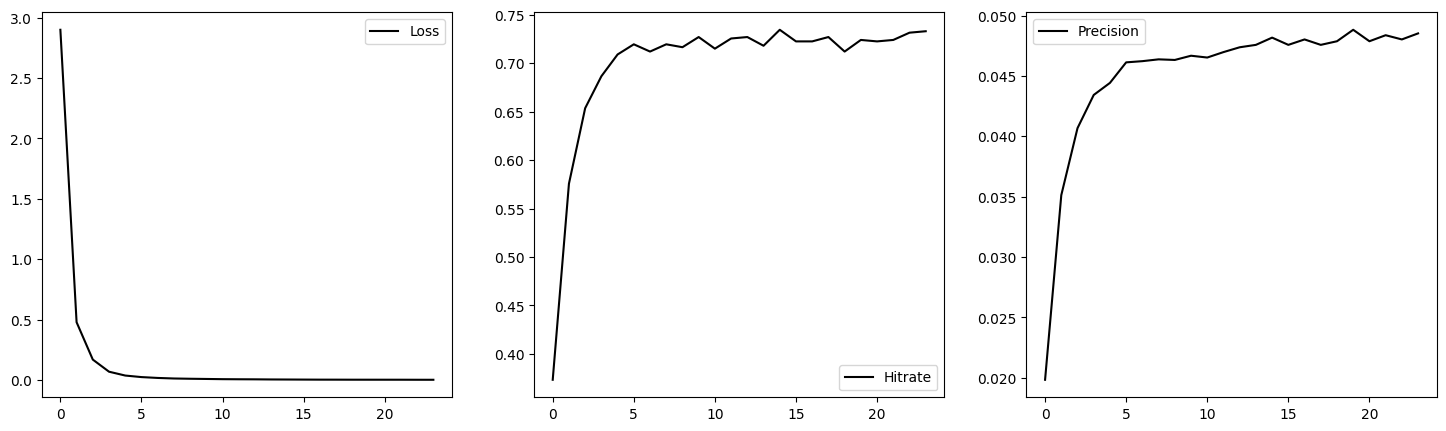

EPOCH LOSS = 0.0028: 100%|██████████████████████| 24/24 [01:55<00:00,  4.79s/it]


Hitrate: 0.7331 | Precision: 0.0485


[I 2024-05-29 01:45:46,356] Trial 49 finished with value: 0.048525737131434286 and parameters: {'batch_size': 5000, 'learning_rate': 0.10685530971733402, 'n_negatives': 4, 'edim': 170, 'n_epochs': 24, 'optimizer_name': 'AdamW'}. Best is trial 43 with value: 0.049625187406296845.


In [62]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

# ALS Model

In [19]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 6.8 MB/s eta 0:00:00m eta 0:00:010:00:01


In [177]:
import numpy as np
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [308]:
run_params = {
    "factors": 100,
    "regularization": 0.01,
    "iterations": 15,
    "alpha": 2.0,
    "n_negatives": 3,
    "n_workers": 0,
    "K": 30,
}

In [406]:
train_dataset = RecDataset(
    df_train['user_index'].values, 
    df_train['node_index'].values, 
    user2seen,
)

dataloader = DataLoader(
    train_dataset, 
    shuffle=True, 
    num_workers=run_params["n_workers"],
    batch_size=len(train_dataset),
    collate_fn=lambda batch: collate_fn(
        batch=batch, 
        num_negatives=run_params["n_negatives"], 
        num_items=df['node_index'].max(),
    ),
)
users, items, labels = next(iter(dataloader))

In [415]:
class ALSModel(nn.Module):
    def __init__(self, factors, regularization, iterations, alpha):
        super(ALSModel, self).__init__()
        self.model = AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            iterations=iterations,
            alpha=alpha,
        )
        self.matrix = None
        self.is_train = False

    def fit(self, users, items, labels, n_negatives):
        labels_ = labels.flatten()
        labels_[labels_ == 0] = -1 # dislike
        users_ = np.repeat(users, n_negatives + 1)
        items_ = items.flatten()
        
        self.matrix = csr_matrix(
            (labels_, (users_, items_)), shape=(len(users_), len(items_))
        )
        self.model.fit(self.matrix)
        self.is_train = True

    def pred_top_k(self, user_id, K: int = 30):
        if not self.is_train:
            raise ValueError("Model should be trained")

        ids, scores = self.model.recommend(
            user_id, self.matrix[user_id], N=K, 
            filter_already_liked_items=False,
        )
        res = np.array([scores, ids])
        return torch.tensor(res)

In [416]:
model = ALSModel(
    factors=run_params["factors"], 
    regularization=run_params["regularization"], 
    iterations=run_params["iterations"],
    alpha=run_params["alpha"],
)

In [417]:
model.fit(users, items, labels, run_params["n_negatives"])

  0%|          | 0/15 [00:00<?, ?it/s]

In [420]:
df_preds = get_preds(model, df_val, run_params)
hitrate = calculate_hitrate(df_preds, run_params["K"])
precision = calculate_precision(df_preds, run_params["K"])
print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")

Hitrate: 0.7391 | Precision: 0.0506


# ALS Pipeline

In [421]:
def run_als(
    factors, regularization, iterations, n_trials,
    n_negatives, alpha,
    run_name: str = "baseline",
) -> float:
    run_params = {
        "factors": factors,
        "regularization": regularization,
        "iterations": iterations,
        "alpha": alpha,
        "n_negatives": n_negatives,
        "n_workers": 0,
        "K": 30,
        "n_trials": n_trials,
    }

    print(run_params)
    model = ALSModel(
        factors=run_params["factors"], 
        regularization=run_params["regularization"], 
        iterations=run_params["iterations"],
        alpha=run_params["alpha"],
    )
    
    dataloader = DataLoader(
        train_dataset, 
        shuffle=True, 
        num_workers=run_params["n_workers"],
        batch_size=len(train_dataset),
        collate_fn=lambda batch: collate_fn(
            batch=batch, 
            num_negatives=run_params["n_negatives"], 
            num_items=df['node_index'].max(),
        ),
    )
    users, items, labels = next(iter(dataloader))
    model.fit(users, items, labels, run_params["n_negatives"])

    with mlflow.start_run(run_name=run_name):
        for param, value in NOTEBOOK_PARAMS.items():
            mlflow.log_param(param, value)
    
        for param, value in run_params.items():
            mlflow.log_param(param, value)

        with torch.no_grad():
            model.eval()
            df_preds = get_preds(model, df_val, run_params)
            
        hitrate = calculate_hitrate(df_preds, run_params["K"])
        precision = calculate_precision(df_preds, run_params["K"])
        print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")
    
        mlflow.log_metrics(
            {
                'hitrate': hitrate,
                'precision': precision, 
            }
        )
        mlflow.log_artifact(NOTEBOOK_PARAMS["notebook_path"])

    return precision

In [422]:
N_TRIALS = 50

In [423]:
def objective(trial) -> float:
    seed_everything(NOTEBOOK_PARAMS["seed"])
    factors = trial.suggest_int('factors', 10, 300)
    regularization = trial.suggest_float('regularization', 1e-3, 5)
    iterations = trial.suggest_int('iterations', 10, 50)
    n_negatives = trial.suggest_int('n_negatives', 1, 10)
    alpha = trial.suggest_float("alpha", 0.1, 15)
    
    precision = run_als(
        factors=factors,
        regularization=regularization,
        iterations=iterations,
        n_negatives=n_negatives, 
        alpha=alpha,
        n_trials=N_TRIALS,
        run_name='ALS_optuna',
    )
    return precision

In [424]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2024-05-30 00:51:06,470] A new study created in memory with name: no-name-8d0cec72-3adc-4c01-9204-0d0c43808d84


{'factors': 39, 'regularization': 0.4444684515351507, 'iterations': 44, 'alpha': 2.038106838846606, 'n_negatives': 1, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/44 [00:00<?, ?it/s]

Hitrate: 0.7346 | Precision: 0.0478


[I 2024-05-30 00:51:15,450] Trial 0 finished with value: 0.047776111944027984 and parameters: {'factors': 39, 'regularization': 0.4444684515351507, 'iterations': 44, 'n_negatives': 1, 'alpha': 2.038106838846606}. Best is trial 0 with value: 0.047776111944027984.


{'factors': 235, 'regularization': 1.3676744240227217, 'iterations': 43, 'alpha': 8.447884251078609, 'n_negatives': 2, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/43 [00:00<?, ?it/s]

Hitrate: 0.7421 | Precision: 0.0510


[I 2024-05-30 00:52:36,467] Trial 1 finished with value: 0.051024487756121936 and parameters: {'factors': 235, 'regularization': 1.3676744240227217, 'iterations': 43, 'n_negatives': 2, 'alpha': 8.447884251078609}. Best is trial 1 with value: 0.051024487756121936.


{'factors': 179, 'regularization': 2.820707914460273, 'iterations': 12, 'alpha': 6.505634530612731, 'n_negatives': 6, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/12 [00:00<?, ?it/s]

Hitrate: 0.7556 | Precision: 0.0513


[I 2024-05-30 00:52:59,043] Trial 2 finished with value: 0.051274362818590706 and parameters: {'factors': 179, 'regularization': 2.820707914460273, 'iterations': 12, 'n_negatives': 6, 'alpha': 6.505634530612731}. Best is trial 2 with value: 0.051274362818590706.


{'factors': 166, 'regularization': 3.16469655370356, 'iterations': 36, 'alpha': 10.667379443839357, 'n_negatives': 2, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/36 [00:00<?, ?it/s]

Hitrate: 0.7466 | Precision: 0.0513


[I 2024-05-30 00:53:26,553] Trial 3 finished with value: 0.051274362818590706 and parameters: {'factors': 166, 'regularization': 3.16469655370356, 'iterations': 36, 'n_negatives': 2, 'alpha': 10.667379443839357}. Best is trial 2 with value: 0.051274362818590706.


{'factors': 115, 'regularization': 1.409835380132823, 'iterations': 11, 'alpha': 2.323872341859815, 'n_negatives': 4, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/11 [00:00<?, ?it/s]

Hitrate: 0.7466 | Precision: 0.0510


[I 2024-05-30 00:53:41,120] Trial 4 finished with value: 0.050974512743628186 and parameters: {'factors': 115, 'regularization': 1.409835380132823, 'iterations': 11, 'n_negatives': 4, 'alpha': 2.323872341859815}. Best is trial 2 with value: 0.051274362818590706.


{'factors': 278, 'regularization': 1.7220183639452824, 'iterations': 29, 'alpha': 9.4695207904608, 'n_negatives': 8, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/29 [00:00<?, ?it/s]

Hitrate: 0.7496 | Precision: 0.0505


[I 2024-05-30 00:56:18,498] Trial 5 finished with value: 0.05047476261869066 and parameters: {'factors': 278, 'regularization': 1.7220183639452824, 'iterations': 29, 'n_negatives': 8, 'alpha': 9.4695207904608}. Best is trial 2 with value: 0.051274362818590706.


{'factors': 65, 'regularization': 0.9538537940358914, 'iterations': 32, 'alpha': 6.748554049989105, 'n_negatives': 6, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/32 [00:00<?, ?it/s]

Hitrate: 0.7421 | Precision: 0.0497


[I 2024-05-30 00:56:39,913] Trial 6 finished with value: 0.04972513743128435 and parameters: {'factors': 65, 'regularization': 0.9538537940358914, 'iterations': 32, 'n_negatives': 6, 'alpha': 6.748554049989105}. Best is trial 2 with value: 0.051274362818590706.


{'factors': 192, 'regularization': 2.680331510883018, 'iterations': 33, 'alpha': 6.279610074224192, 'n_negatives': 10, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/33 [00:00<?, ?it/s]

Hitrate: 0.7526 | Precision: 0.0508


[I 2024-05-30 00:57:48,461] Trial 7 finished with value: 0.050824587706146916 and parameters: {'factors': 192, 'regularization': 2.680331510883018, 'iterations': 33, 'n_negatives': 10, 'alpha': 6.279610074224192}. Best is trial 2 with value: 0.051274362818590706.


{'factors': 120, 'regularization': 2.7130496366690293, 'iterations': 42, 'alpha': 8.305849248818278, 'n_negatives': 4, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/42 [00:00<?, ?it/s]

Hitrate: 0.7571 | Precision: 0.0515


[I 2024-05-30 00:58:22,621] Trial 8 finished with value: 0.05152423788105947 and parameters: {'factors': 120, 'regularization': 2.7130496366690293, 'iterations': 42, 'n_negatives': 4, 'alpha': 8.305849248818278}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 211, 'regularization': 0.3813166289939575, 'iterations': 16, 'alpha': 13.732901115670689, 'n_negatives': 9, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/16 [00:00<?, ?it/s]

Hitrate: 0.7556 | Precision: 0.0513


[I 2024-05-30 00:59:32,841] Trial 9 finished with value: 0.051274362818590706 and parameters: {'factors': 211, 'regularization': 0.3813166289939575, 'iterations': 16, 'n_negatives': 9, 'alpha': 13.732901115670689}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 112, 'regularization': 4.1583176774757575, 'iterations': 50, 'alpha': 13.507688341125377, 'n_negatives': 4, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Hitrate: 0.7481 | Precision: 0.0506


[I 2024-05-30 01:00:08,045] Trial 10 finished with value: 0.05057471264367816 and parameters: {'factors': 112, 'regularization': 4.1583176774757575, 'iterations': 50, 'n_negatives': 4, 'alpha': 13.507688341125377}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 117, 'regularization': 3.440976041453802, 'iterations': 22, 'alpha': 4.522961607020587, 'n_negatives': 6, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/22 [00:00<?, ?it/s]

Hitrate: 0.7571 | Precision: 0.0513


[I 2024-05-30 01:00:33,475] Trial 11 finished with value: 0.051274362818590706 and parameters: {'factors': 117, 'regularization': 3.440976041453802, 'iterations': 22, 'n_negatives': 6, 'alpha': 4.522961607020587}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 163, 'regularization': 2.249299247136477, 'iterations': 23, 'alpha': 4.4405789783225185, 'n_negatives': 4, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/23 [00:00<?, ?it/s]

Hitrate: 0.7511 | Precision: 0.0515


[I 2024-05-30 01:00:57,714] Trial 12 finished with value: 0.05147426286856571 and parameters: {'factors': 163, 'regularization': 2.249299247136477, 'iterations': 23, 'n_negatives': 4, 'alpha': 4.4405789783225185}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 76, 'regularization': 4.973958471480088, 'iterations': 25, 'alpha': 3.9943760477278976, 'n_negatives': 4, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/25 [00:00<?, ?it/s]

Hitrate: 0.7556 | Precision: 0.0505


[I 2024-05-30 01:01:16,386] Trial 13 finished with value: 0.050474762618690654 and parameters: {'factors': 76, 'regularization': 4.973958471480088, 'iterations': 25, 'n_negatives': 4, 'alpha': 3.9943760477278976}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 137, 'regularization': 2.085010878358044, 'iterations': 39, 'alpha': 0.5134043928593872, 'n_negatives': 3, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/39 [00:00<?, ?it/s]

Hitrate: 0.3058 | Precision: 0.0125


[I 2024-05-30 01:01:45,370] Trial 14 finished with value: 0.012543728135932035 and parameters: {'factors': 137, 'regularization': 2.085010878358044, 'iterations': 39, 'n_negatives': 3, 'alpha': 0.5134043928593872}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 234, 'regularization': 3.7268354338714893, 'iterations': 21, 'alpha': 11.579489544756374, 'n_negatives': 5, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/21 [00:00<?, ?it/s]

Hitrate: 0.7466 | Precision: 0.0507


[I 2024-05-30 01:02:46,853] Trial 15 finished with value: 0.050674662668665674 and parameters: {'factors': 234, 'regularization': 3.7268354338714893, 'iterations': 21, 'n_negatives': 5, 'alpha': 11.579489544756374}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 28, 'regularization': 2.309136059274688, 'iterations': 50, 'alpha': 4.536953279806801, 'n_negatives': 7, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Hitrate: 0.7196 | Precision: 0.0459


[I 2024-05-30 01:03:07,006] Trial 16 finished with value: 0.045877061469265366 and parameters: {'factors': 28, 'regularization': 2.309136059274688, 'iterations': 50, 'n_negatives': 7, 'alpha': 4.536953279806801}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 146, 'regularization': 2.221647782635458, 'iterations': 25, 'alpha': 8.575841395496145, 'n_negatives': 5, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/25 [00:00<?, ?it/s]

Hitrate: 0.7496 | Precision: 0.0513


[I 2024-05-30 01:03:34,215] Trial 17 finished with value: 0.051274362818590706 and parameters: {'factors': 146, 'regularization': 2.221647782635458, 'iterations': 25, 'n_negatives': 5, 'alpha': 8.575841395496145}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 84, 'regularization': 3.9165193293111153, 'iterations': 17, 'alpha': 11.518342701815364, 'n_negatives': 2, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/17 [00:00<?, ?it/s]

Hitrate: 0.7526 | Precision: 0.0506


[I 2024-05-30 01:03:46,335] Trial 18 finished with value: 0.05057471264367816 and parameters: {'factors': 84, 'regularization': 3.9165193293111153, 'iterations': 17, 'n_negatives': 2, 'alpha': 11.518342701815364}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 282, 'regularization': 4.476943631468983, 'iterations': 42, 'alpha': 5.443025501269302, 'n_negatives': 3, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/42 [00:00<?, ?it/s]

Hitrate: 0.7436 | Precision: 0.0509


[I 2024-05-30 01:05:34,211] Trial 19 finished with value: 0.05092453773113444 and parameters: {'factors': 282, 'regularization': 4.476943631468983, 'iterations': 42, 'n_negatives': 3, 'alpha': 5.443025501269302}. Best is trial 8 with value: 0.05152423788105947.


{'factors': 211, 'regularization': 3.131412233632151, 'iterations': 28, 'alpha': 2.869178953923513, 'n_negatives': 7, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/28 [00:00<?, ?it/s]

Hitrate: 0.7481 | Precision: 0.0516


[I 2024-05-30 01:07:08,819] Trial 20 finished with value: 0.05157421289355322 and parameters: {'factors': 211, 'regularization': 3.131412233632151, 'iterations': 28, 'n_negatives': 7, 'alpha': 2.869178953923513}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 215, 'regularization': 3.0111846050625015, 'iterations': 28, 'alpha': 2.824694942488767, 'n_negatives': 7, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/28 [00:00<?, ?it/s]

Hitrate: 0.7481 | Precision: 0.0515


[I 2024-05-30 01:08:42,853] Trial 21 finished with value: 0.05147426286856571 and parameters: {'factors': 215, 'regularization': 3.0111846050625015, 'iterations': 28, 'n_negatives': 7, 'alpha': 2.824694942488767}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 151, 'regularization': 3.3668873678299587, 'iterations': 36, 'alpha': 1.075459240172128, 'n_negatives': 7, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/36 [00:00<?, ?it/s]

Hitrate: 0.7211 | Precision: 0.0480


[I 2024-05-30 01:09:28,311] Trial 22 finished with value: 0.04802598700649675 and parameters: {'factors': 151, 'regularization': 3.3668873678299587, 'iterations': 36, 'n_negatives': 7, 'alpha': 1.075459240172128}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 254, 'regularization': 2.4971198533964585, 'iterations': 25, 'alpha': 3.412250996316181, 'n_negatives': 5, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/25 [00:00<?, ?it/s]

Hitrate: 0.7421 | Precision: 0.0510


[I 2024-05-30 01:11:48,402] Trial 23 finished with value: 0.051024487756121936 and parameters: {'factors': 254, 'regularization': 2.4971198533964585, 'iterations': 25, 'n_negatives': 5, 'alpha': 3.412250996316181}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 192, 'regularization': 2.000078242497988, 'iterations': 19, 'alpha': 7.662903478562012, 'n_negatives': 3, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/19 [00:00<?, ?it/s]

Hitrate: 0.7526 | Precision: 0.0513


[I 2024-05-30 01:12:08,756] Trial 24 finished with value: 0.051274362818590706 and parameters: {'factors': 192, 'regularization': 2.000078242497988, 'iterations': 19, 'n_negatives': 3, 'alpha': 7.662903478562012}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 95, 'regularization': 1.750346513855498, 'iterations': 32, 'alpha': 5.601438570576932, 'n_negatives': 8, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/32 [00:00<?, ?it/s]

Hitrate: 0.7586 | Precision: 0.0505


[I 2024-05-30 01:12:45,701] Trial 25 finished with value: 0.05052473763118441 and parameters: {'factors': 95, 'regularization': 1.750346513855498, 'iterations': 32, 'n_negatives': 8, 'alpha': 5.601438570576932}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 168, 'regularization': 2.986204448933992, 'iterations': 28, 'alpha': 1.7019954309314516, 'n_negatives': 4, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/28 [00:00<?, ?it/s]

Hitrate: 0.7436 | Precision: 0.0513


[I 2024-05-30 01:13:15,783] Trial 26 finished with value: 0.051324337831084456 and parameters: {'factors': 168, 'regularization': 2.986204448933992, 'iterations': 28, 'n_negatives': 4, 'alpha': 1.7019954309314516}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 132, 'regularization': 3.555382304188049, 'iterations': 47, 'alpha': 5.112022118321143, 'n_negatives': 8, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/47 [00:00<?, ?it/s]

Hitrate: 0.7511 | Precision: 0.0513


[I 2024-05-30 01:14:07,217] Trial 27 finished with value: 0.051324337831084456 and parameters: {'factors': 132, 'regularization': 3.555382304188049, 'iterations': 47, 'n_negatives': 8, 'alpha': 5.112022118321143}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 300, 'regularization': 2.4602760527858165, 'iterations': 37, 'alpha': 3.24163735343062, 'n_negatives': 5, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/37 [00:00<?, ?it/s]

Hitrate: 0.7466 | Precision: 0.0510


[I 2024-05-30 01:16:05,026] Trial 28 finished with value: 0.050974512743628186 and parameters: {'factors': 300, 'regularization': 2.4602760527858165, 'iterations': 37, 'n_negatives': 5, 'alpha': 3.24163735343062}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 51, 'regularization': 0.8246316900432136, 'iterations': 22, 'alpha': 7.601719863261747, 'n_negatives': 1, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/22 [00:00<?, ?it/s]

Hitrate: 0.7466 | Precision: 0.0491


[I 2024-05-30 01:16:12,315] Trial 29 finished with value: 0.04912543728135932 and parameters: {'factors': 51, 'regularization': 0.8246316900432136, 'iterations': 22, 'n_negatives': 1, 'alpha': 7.601719863261747}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 203, 'regularization': 2.720165591556184, 'iterations': 40, 'alpha': 9.832361772139311, 'n_negatives': 1, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/40 [00:00<?, ?it/s]

Hitrate: 0.7451 | Precision: 0.0515


[I 2024-05-30 01:17:07,879] Trial 30 finished with value: 0.05147426286856571 and parameters: {'factors': 203, 'regularization': 2.720165591556184, 'iterations': 40, 'n_negatives': 1, 'alpha': 9.832361772139311}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 234, 'regularization': 3.132213781729635, 'iterations': 27, 'alpha': 1.515129530247258, 'n_negatives': 7, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/27 [00:00<?, ?it/s]

Hitrate: 0.7451 | Precision: 0.0512


[I 2024-05-30 01:18:37,952] Trial 31 finished with value: 0.051174412793603186 and parameters: {'factors': 234, 'regularization': 3.132213781729635, 'iterations': 27, 'n_negatives': 7, 'alpha': 1.515129530247258}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 221, 'regularization': 2.9878549072669864, 'iterations': 31, 'alpha': 2.7144940824462007, 'n_negatives': 7, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/31 [00:00<?, ?it/s]

Hitrate: 0.7481 | Precision: 0.0511


[I 2024-05-30 01:20:29,251] Trial 32 finished with value: 0.051074462768615686 and parameters: {'factors': 221, 'regularization': 2.9878549072669864, 'iterations': 31, 'n_negatives': 7, 'alpha': 2.7144940824462007}. Best is trial 20 with value: 0.05157421289355322.


{'factors': 177, 'regularization': 2.699644745630464, 'iterations': 27, 'alpha': 3.7118064519704, 'n_negatives': 6, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/27 [00:00<?, ?it/s]

Hitrate: 0.7571 | Precision: 0.0517


[I 2024-05-30 01:21:04,999] Trial 33 finished with value: 0.05172413793103448 and parameters: {'factors': 177, 'regularization': 2.699644745630464, 'iterations': 27, 'n_negatives': 6, 'alpha': 3.7118064519704}. Best is trial 33 with value: 0.05172413793103448.


{'factors': 179, 'regularization': 0.07839624999602535, 'iterations': 45, 'alpha': 3.988509538806713, 'n_negatives': 6, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/45 [00:00<?, ?it/s]

Hitrate: 0.7481 | Precision: 0.0511


[I 2024-05-30 01:21:58,872] Trial 34 finished with value: 0.051074462768615686 and parameters: {'factors': 179, 'regularization': 0.07839624999602535, 'iterations': 45, 'n_negatives': 6, 'alpha': 3.988509538806713}. Best is trial 33 with value: 0.05172413793103448.


{'factors': 167, 'regularization': 1.7545370853774147, 'iterations': 34, 'alpha': 0.26910011941642287, 'n_negatives': 6, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/34 [00:00<?, ?it/s]

[W 2024-05-30 01:22:35,110] Trial 35 failed with parameters: {'factors': 167, 'regularization': 1.7545370853774147, 'iterations': 34, 'n_negatives': 6, 'alpha': 0.26910011941642287} because of the following error: ModelFitError('NaN encountered in factors').
Traceback (most recent call last):
  File "/home/user/.pyenv/versions/3.10.9/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_7480/2902507591.py", line 9, in objective
    precision = run_als(
  File "/tmp/ipykernel_7480/776379376.py", line 37, in run_als
    model.fit(users, items, labels, run_params["n_negatives"])
  File "/tmp/ipykernel_7480/1379824865.py", line 22, in fit
    self.model.fit(self.matrix)
  File "/home/user/.pyenv/versions/3.10.9/lib/python3.10/site-packages/implicit/cpu/als.py", line 201, in fit
    self._check_fit_errors()
  File "/home/user/.pyenv/versions/3.10.9/lib/python3.10/site-packages/implicit/cpu/matrix_factorizati

ModelFitError: NaN encountered in factors